# Maestría en Ciencia de Datos - Fundamentos de Analítica II
## Daniel Martínez Villegas - Felipe Montenegro Fuentes 
### Taller II

# 1. Librerías

In [31]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 2. Carga de Datos

In [32]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


# 3. Protocolo de Evaluación

In [33]:
# Se lleva acabo la división de lso datos en conjunto de entrenamiento y datos de prueba, para ello nos enfocaremos en los datos de ocupados. 

train_socupados = data[["Ocupados"]][:len(data)-6] #Se está tomando todos los datos menos los 10 últimos
test_socupados = data[["Ocupados"]][len(data)-6:len(data)] #Se están tomando los restantes

In [34]:
print(test_socupados)

             Ocupados
mes                  
2018-11-01  10783.299
2018-12-01  10835.398
2019-01-01  10314.438
2019-02-01  10557.917
2019-03-01  10760.776
2019-04-01  10632.028


Una vez realizado el protocolo de evaluación, el objetivo de este ejercicio es evaluar diferentes combinaciones de modelos para estimar la tendencia y la estacionalidad de la serie de ocupados de los datos provistos por el DANE. Para ello vamos a generar inicialmente una función que nos permita evaluar la tendencia de la serie usando tres ordenes: 

- Lineal
- Cuadrática 
- Polinómica

# Generación de la función

In [35]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

def fit_polynomial_model(order, train_data, test_data, h=6):
    # Paso 1: Definir las variables independientes y dependientes
    y = train_data
    x = np.linspace(1, len(train_data), len(train_data))
    
    # Generar las características polinómicas
    X = np.vander(x, N=order+1, increasing=True)
    
    # Ajustar el modelo
    model = sm.OLS(y, X)
    model_fit = model.fit()
    print(f"Resumen del modelo de orden {order}:")
    print(model_fit.summary())

    # Paso 2: Graficar los residuos del modelo
    print("Los residuos del modelo son los siguientes:")
    plt.figure(figsize=(10, 6))
    plt.ylabel("Residuales del modelo")
    plt.plot(model_fit.resid)
    plt.grid()
    plt.show()
    
    # Paso 3: Graficar la tendencia ajustada vs. la serie original
    print("Graficamos la serie original y la tendencia")
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Ocupados")
    plt.plot(model_fit.fittedvalues, label=f"Tendencia de Orden {order}")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Paso 4: Pronóstico para h periodos
    x_for = np.linspace(len(train_data) + 1, len(train_data) + h, h)
    X_for = np.vander(x_for, N=order+1, increasing=True)
    
    # Obtener los pronósticos con intervalos de confianza
    dt = model_fit.get_prediction(X_for).summary_frame(alpha=0.05)
    y_prd = dt['mean']
    yprd_ci_lower = dt['obs_ci_lower']
    yprd_ci_upper = dt['obs_ci_upper']
    
    preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
    
    print("Realizamos el pronóstico para un horizonte de 6 periodos")
    print(preds)
    
    # Paso 5: Gráfica de los datos de entrenamiento y los pronósticos
    print("Graficamos la serie original y el pronóstico estimado para los próximos 6 meses")
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label="Datos Entrenamiento")
    plt.plot(x_for, preds['Point_forecast'], label=f"Tendencia de Orden {order}")
    plt.fill_between(x_for, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
    plt.legend()
    plt.show()

    # Paso 6: Cálculo del RMSE
    rmse = np.sqrt(mean_squared_error(test_data, preds['Point_forecast']))
    print(f"RMSE - Modelo de Orden {order}: {rmse}")
    
    return model_fit, preds, rmse

# 4. Modelo - Tendencia Lineal

Resumen del modelo de orden 1:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     5439.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):          4.10e-153
Time:                        12:57:45   Log-Likelihood:                -1483.6
No. Observations:                 214   AIC:                             2971.
Df Residuals:                     212   BIC:                             2978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6916.5808

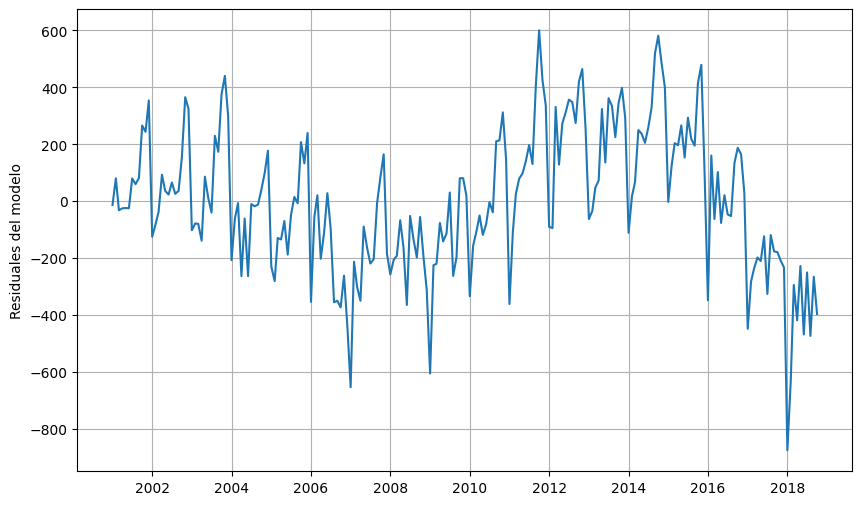

Graficamos la serie original y la tendencia


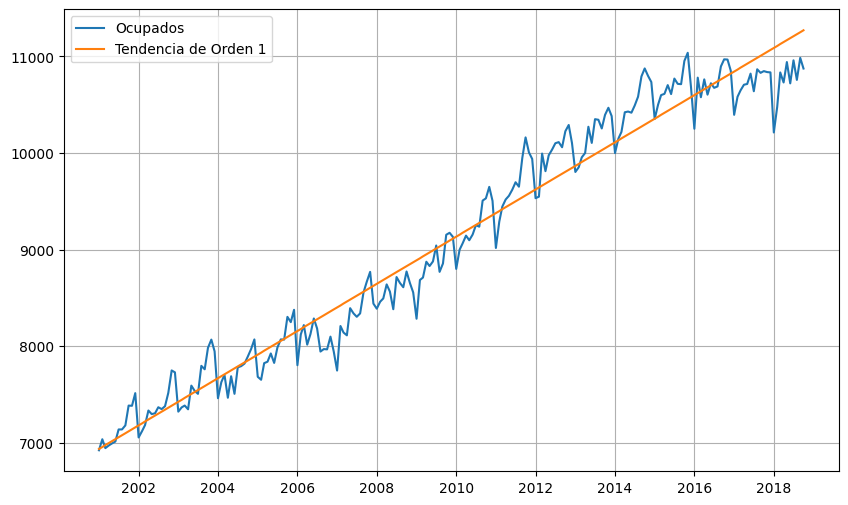

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    11290.562073  10794.552484  11786.571663
1    11310.906172  10814.832205  11806.980139
2    11331.250271  10835.111339  11827.389204
3    11351.594370  10855.389885  11847.798855
4    11371.938469  10875.667843  11868.209094
5    11392.282568  10895.945215  11888.619920
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


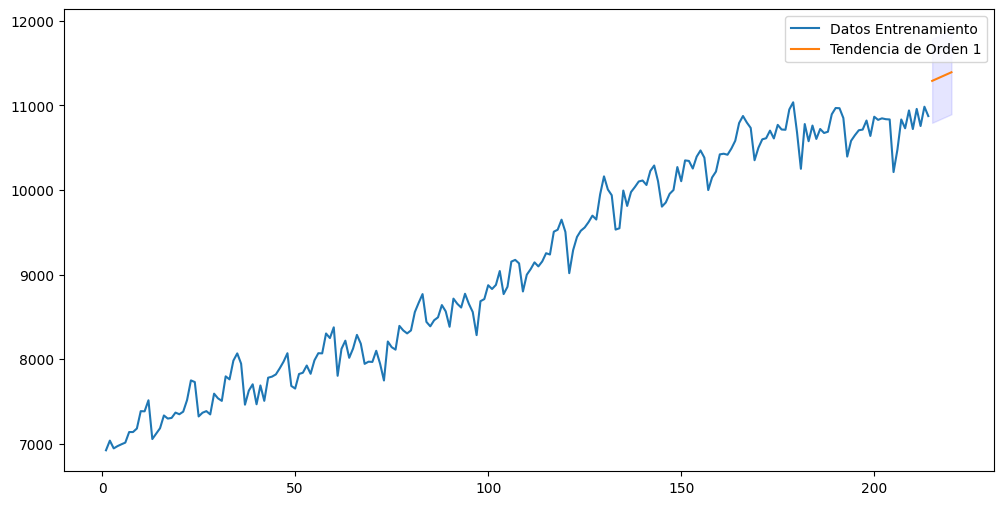

RMSE - Modelo de Orden 1: 718.651675100173


In [36]:
model_fit_lin, preds_lin, rmse_lin = fit_polynomial_model(order=1, train_data=train_socupados, test_data=test_socupados)

# 4.2 Modelo de Tendencia Cuadrática

Resumen del modelo de orden 2:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2750.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):          7.46e-152
Time:                        12:57:53   Log-Likelihood:                -1482.0
No. Observations:                 214   AIC:                             2970.
Df Residuals:                     211   BIC:                             2980.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6846.9680

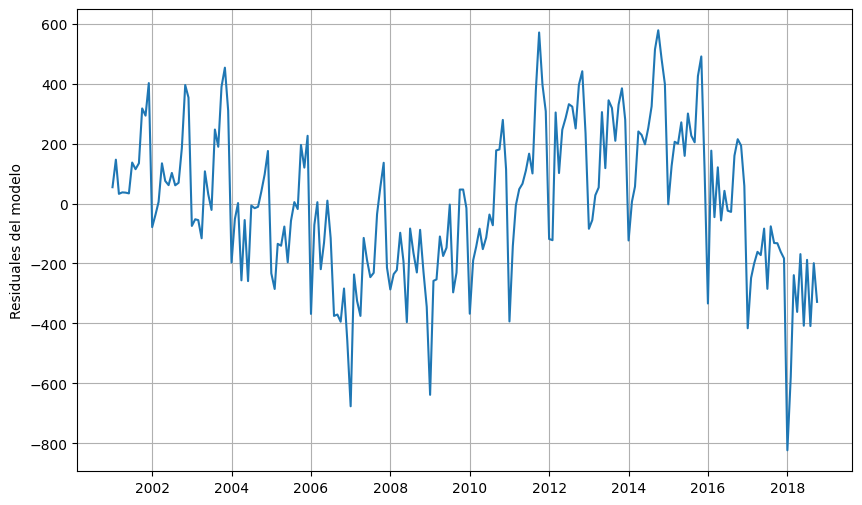

Graficamos la serie original y la tendencia


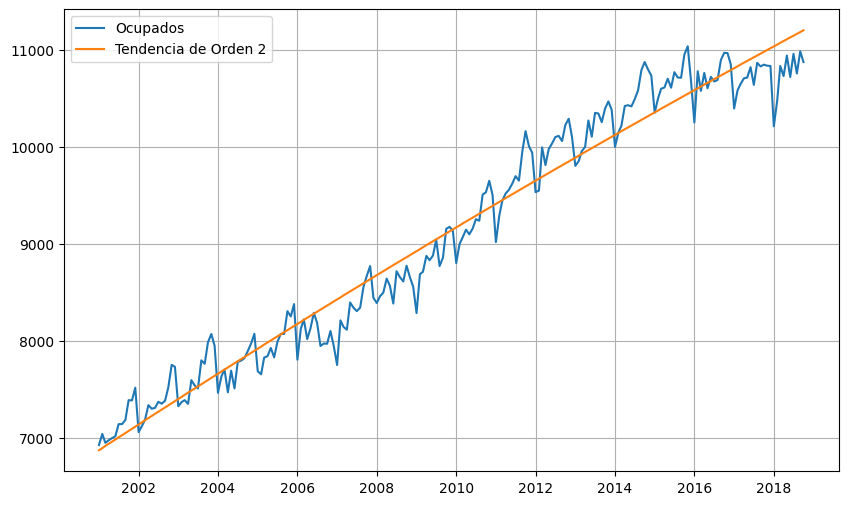

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    11220.949257  10721.787967  11720.110547
1    11239.350672  10739.800787  11738.900558
2    11257.734100  10757.783260  11757.684941
3    11276.099540  10775.735164  11776.463916
4    11294.446992  10793.656279  11795.237705
5    11312.776457  10811.546382  11814.006531
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


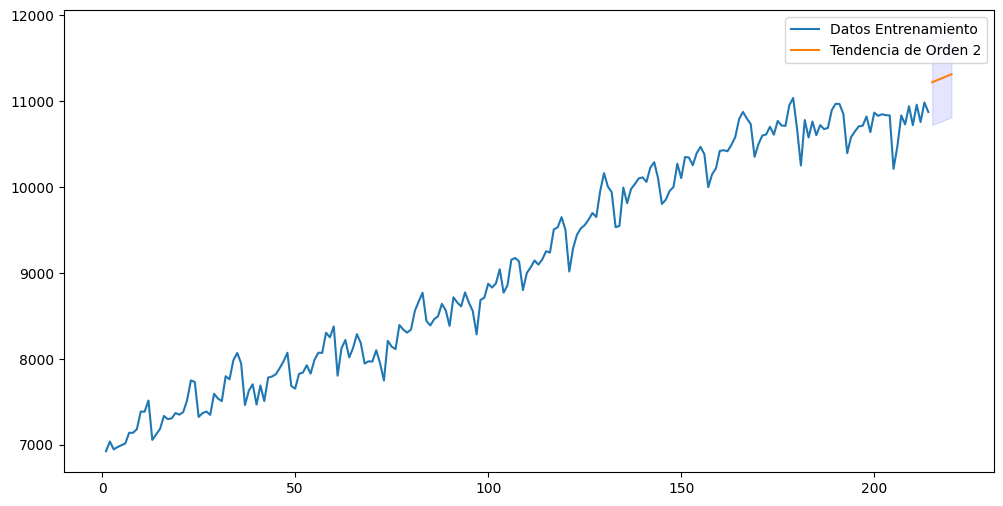

RMSE - Modelo de Orden 2: 646.5978131678402


In [37]:
model_fit_quad, preds_quad, rmse_quad = fit_polynomial_model(order=2, train_data=train_socupados, test_data=test_socupados)

# 4.3 Modelo - Tendencia Polinómica 

Resumen del modelo de orden 3:
                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2873.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):          3.73e-170
Time:                        12:58:02   Log-Likelihood:                -1434.9
No. Observations:                 214   AIC:                             2878.
Df Residuals:                     210   BIC:                             2891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7246.7790

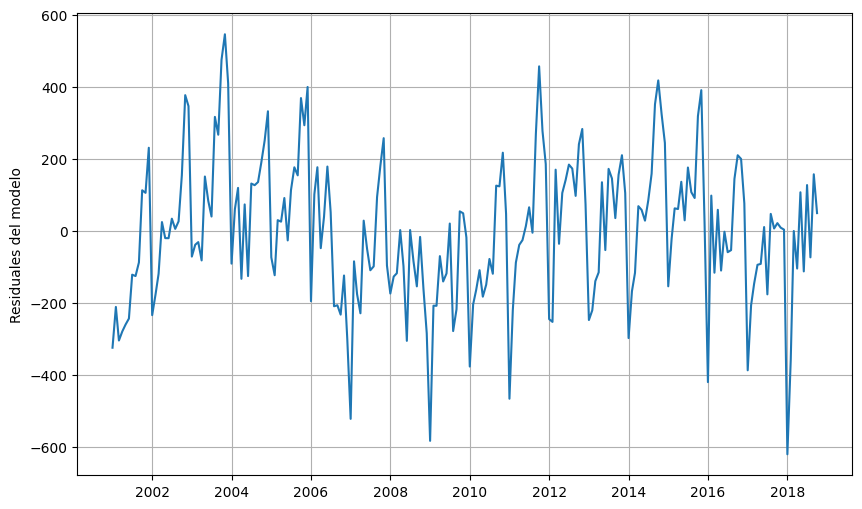

Graficamos la serie original y la tendencia


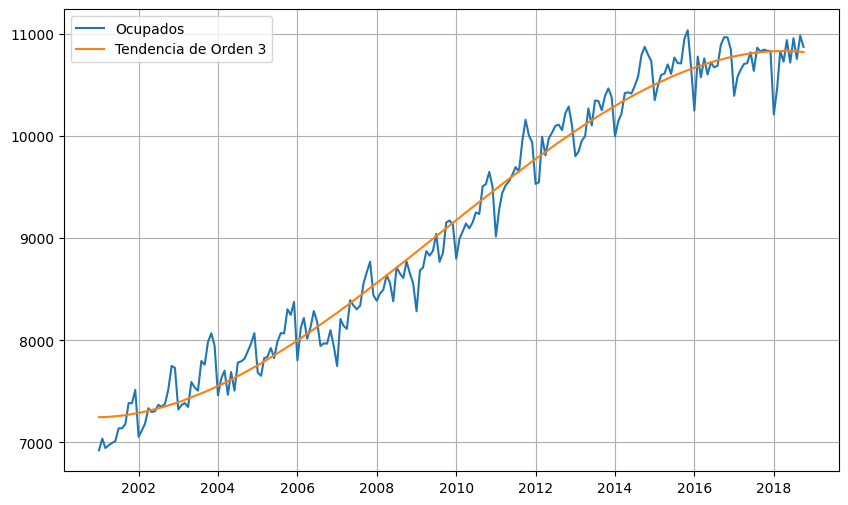

Realizamos el pronóstico para un horizonte de 6 periodos
   Point_forecast      lower_95      upper_95
0    10821.138290  10413.038112  11229.238468
1    10817.224675  10408.066442  11226.382908
2    10812.776520  10402.493637  11223.059404
3    10807.789065  10396.312228  11219.265902
4    10802.257549  10389.514708  11215.000391
5    10796.177211  10382.093533  11210.260890
Graficamos la serie original y el pronóstico estimado para los próximos 6 meses


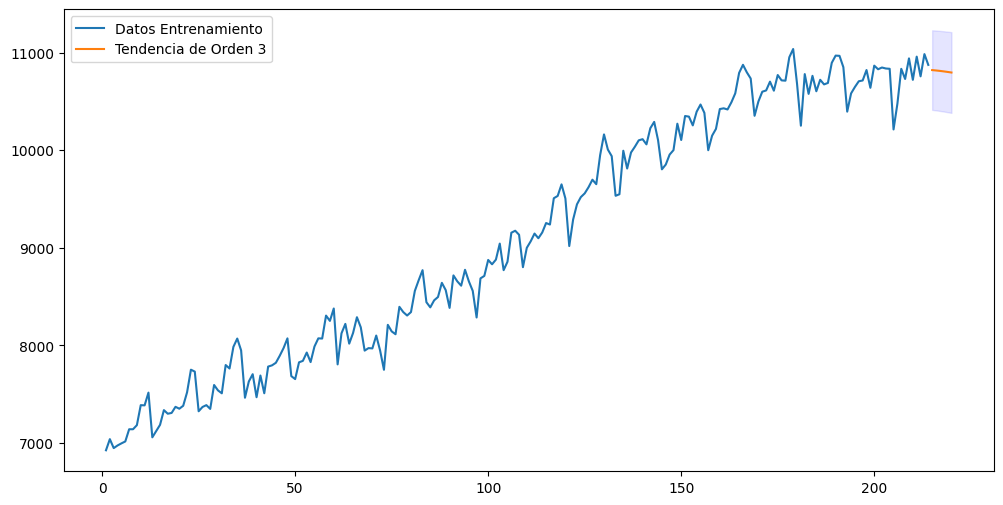

RMSE - Modelo de Orden 3: 238.46910836422933


In [38]:
model_fit_cubic, preds_cubic, rmse_cubic = fit_polynomial_model(order=3, train_data=train_socupados, test_data=test_socupados)

A continuación, procedemos a estimar la estacionalidad de la serie.

# 5. Estimación de Estacionalidad

In [39]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
month_dummies = month_dummies.astype(float)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2787
Date:                Sun, 11 Aug 2024   Prob (F-statistic):              0.989
Time:                        12:58:22   Log-Likelihood:                -1886.0
No. Observations:                 220   AIC:                             3796.
Df Residuals:                     208   BIC:                             3837.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    301.805     29.185      0.0

In [40]:
print(month_dummies)

             2    3    4    5    6    7    8    9    10   11   12
mes                                                              
2001-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2001-02-01  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2001-03-01  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2001-04-01  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2001-05-01  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2018-12-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
2019-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2019-02-01  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2019-03-01  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2019-04-01  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[220 rows x 11 columns]


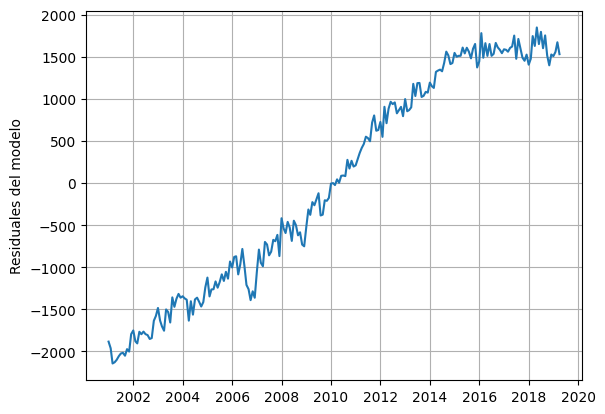

In [41]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

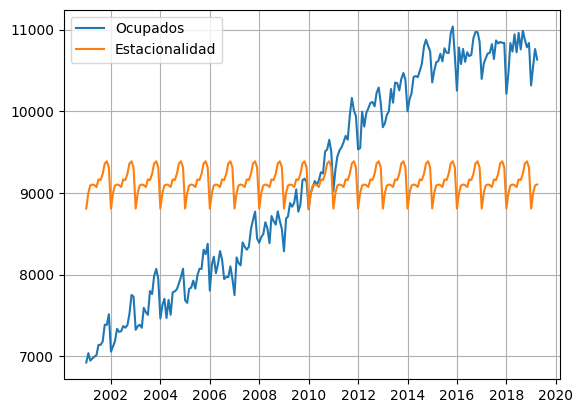

In [42]:
plt.plot(y,label="Ocupados")
plt.plot(season.fittedvalues,label="Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [43]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for)

In [44]:
print(x_for.dtypes)
print(X_for.dtypes)

'''Los datos en x_for y X_for contienen columnas con el tipo bool y object,
que pueden estar causando problemas cuando intentas pasar estos datos a un modelo de statsmodels. 
El modelo espera datos numéricos (float64, int64, etc.) en lugar de datos booleanos u objetos.'''


2     bool
3     bool
4     bool
5     bool
6     bool
7     bool
8     bool
9     bool
10    bool
11    bool
12    bool
dtype: object
const    float64
2           bool
3           bool
4           bool
5           bool
6           bool
7           bool
8           bool
9           bool
10          bool
11          bool
12          bool
dtype: object


'Los datos en x_for y X_for contienen columnas con el tipo bool y object,\nque pueden estar causando problemas cuando intentas pasar estos datos a un modelo de statsmodels. \nEl modelo espera datos numéricos (float64, int64, etc.) en lugar de datos booleanos u objetos.'

In [45]:
x_for = x_for.apply(lambda x: x.astype(int))
X_for = sm.add_constant(x_for)


In [46]:
print(X_for.dtypes)


const    float64
2          int32
3          int32
4          int32
5          int32
6          int32
7          int32
8          int32
9          int32
10         int32
11         int32
12         int32
dtype: object


In [47]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-05-01     9095.089000  6430.527026  11759.650974
2019-06-01     9071.789000  6407.227026  11736.350974
2019-07-01     9164.935167  6500.373193  11829.497140
2019-08-01     9156.633500  6492.071526  11821.195474
2019-09-01     9232.988500  6568.426526  11897.550474
2019-10-01     9359.934944  6695.372971  12024.496918
2019-11-01     9386.702222  6722.140249  12051.264196
2019-12-01     9310.332667  6645.770693  11974.894640
2020-01-01     8808.217632  6147.348746  11469.086517
2020-02-01     9001.037684  6340.168799  11661.906569
2020-03-01     9090.037158  6429.168273  11750.906043
2020-04-01     9102.647316  6441.778431  11763.516201


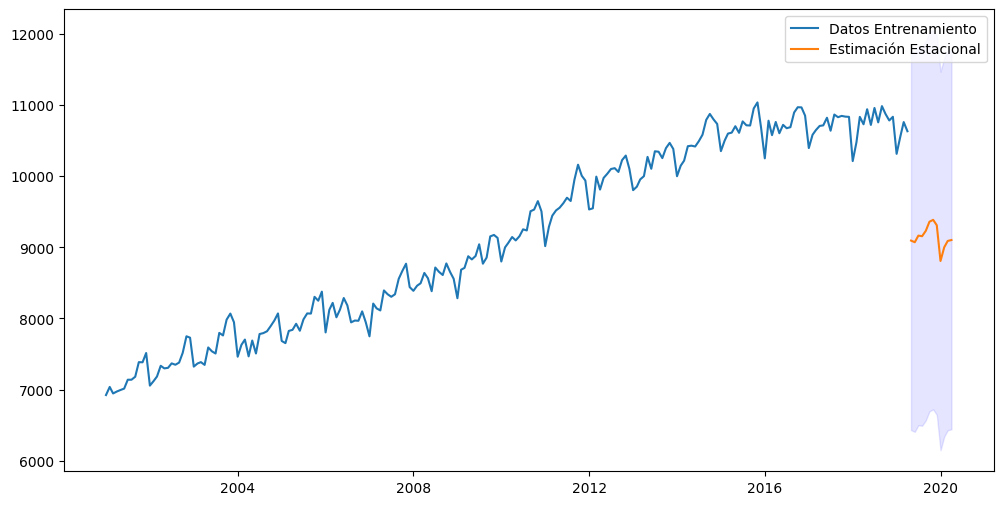

In [48]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [49]:
# Cálculo del RMSE

fitted_values = season.fittedvalues
errors = y - fitted_values
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Guardar el RMSE en una variable
rmse_estacionalidad = rmse

RMSE: 1279.1551318629215


# 6. Combinación de los Modelos


- Tendencia Lineal + Estacionalidad 
- Tendencia Cuadrática + Estacionalidad
- Tendencia Polinómica + Estacinoalidad

# 7. Pronóstico utilizando el Mejor Modelo 

Previamente debemos evalular los RMSE para seleccionar el mejor modelo para predecir. En este punto debemos usar TODOS los datos.

# 8. Validación de Supuestos 

Debemos validar los supuestos enfocandos en los residuales del último modelo.

# 9. Comparación del modelo de este ejercicio Vs. Mejor modelo del taller anterio

# 10. Conclusiones y Limitaciones